In [1]:
import numpy as np
#Create a Circular 
R = 4
N_r = 10
N_theta = 16
R_step = R/N_r
Theta_step = 2*np.pi/N_theta
Nnode = N_r*N_theta +1 #centre treated separately
coord = []
neigh = [None]*Nnode

coord.append(np.array([0.,0.]))
neigh[0] = list(range(1,N_theta+1))

for i in range(1,Nnode):
    j = i-1
    coord.append(np.array([R_step + (j//N_theta)*R_step, (j%N_theta)*Theta_step]))
    if j//N_theta==0: #condition to be neighbour of central node
        bottom = 0
    else: 
        bottom = j-N_theta +1
    top = j + N_theta +1
    if j%N_theta == 0:
        left = j +N_theta-1 +1
    else: 
        left = j -1 +1
    if (j+1)%N_theta==0:
        right = (j//N_theta)*N_theta +1
    else:
        right = j +1 +1
    if j//N_theta +1 == N_r: #condition to be on the boundary
        neigh[i] = [left, bottom, right]
    else:
        neigh[i] = [top, left, bottom, right]

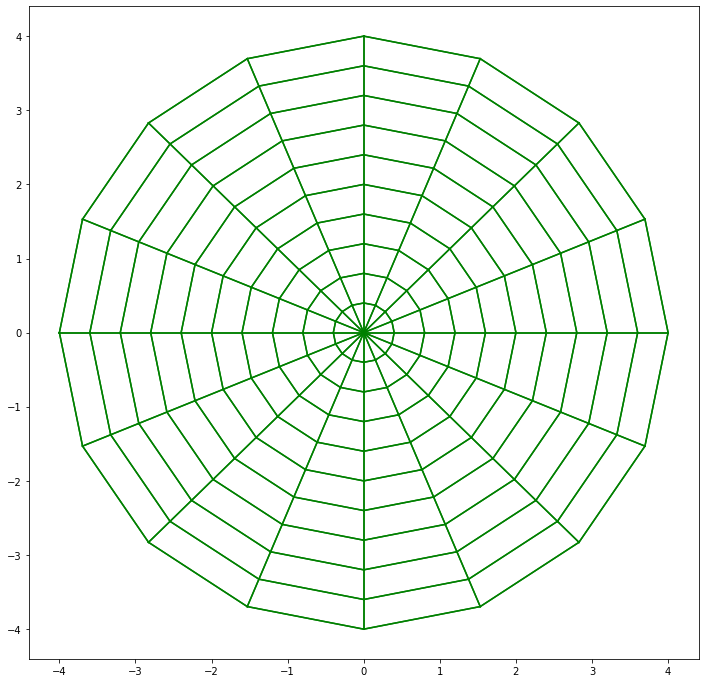

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
for i in range (Nnode):
    for j in range (len(neigh[i])):
        r1 = coord[i][0]
        r2 = coord[neigh[i][j]][0]
        theta1 = coord[i][1]
        theta2 = coord[neigh[i][j]][1]
        x1 = r1*np.cos(theta1)
        x2 = r2*np.cos(theta2)
        y1 = r1*np.sin(theta1)
        y2 = r2*np.sin(theta2)
        ax.plot([x1,x2], [y1,y2], 'g-')

In [3]:
#Transform Into Square Mesh
for i in range(1,Nnode):
        r     = coord[i][0]
        theta = coord[i][1]
        x0 = r*np.cos(theta)
        y0 = r*np.sin(theta)
        if (r>2.):
            if x0>0:
                if np.abs(y0)<np.abs(x0):
                    x1 = r
                    y1 = r*y0/x0
                else:
                    x1 = r*x0/np.abs(y0)
                    y1 = (int(y0>0)-0.5)*2*r
            else:
                if np.abs(y0)<np.abs(x0):
                    x1 = -r
                    y1 = r*y0/(-x0)
                else:
                    y1 = (int(y0>0)-0.5)*2*r
                    x1 = r*x0/np.abs(y0)
            t = (r-2.0)*0.5
            coord[i] = np.array([t*x1+(1-t)*x0, t*y1+(1-t)*y0])
        else:
            coord[i] = np.array([x0,y0])

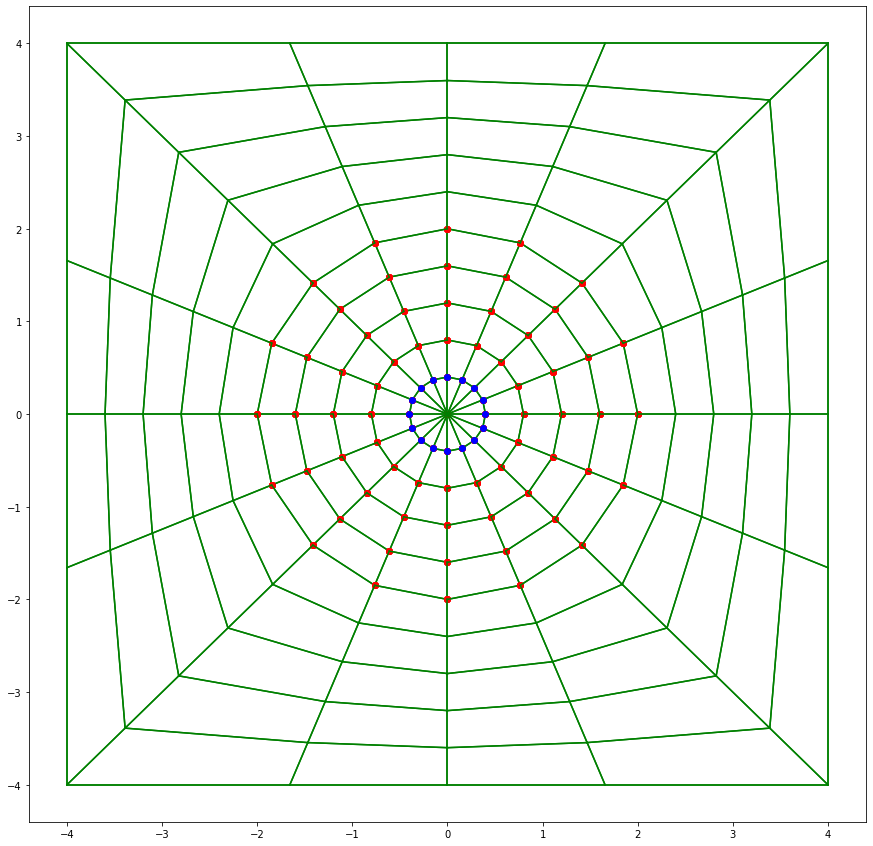

In [5]:
# Mark interior vs exterior points
inside = [Nnode]*Nnode
for i in range(Nnode):
    if (np.sqrt(coord[i][0]**2 + coord[i][1]**2)<2.0+1e-6):
        inside[i]=1
    else:
        inside[i]=0
        
fig, ax = plt.subplots(figsize = (15,15))
for i in range (Nnode):
    for j in range (len(neigh[i])):
        x1 = coord[i][0]
        x2 = coord[neigh[i][j]][0]
        y1 = coord[i][1]
        y2 = coord[neigh[i][j]][1]
        ax.plot([x1,x2], [y1,y2], 'g-')
        if inside[i]==1:
            ax.plot(x1,y1, 'ro')
for j in range(len(neigh[0])):
    ax.plot(coord[neigh[0][j]][0], coord[neigh[0][j]][1], 'bo') 

In [331]:
# FINITE VOLUMES WITH INTERFACE CORRECTION
Lambda = 0.1
invLambda = 1/Lambda
# Calculation of $\omega_ij$ 
omega = [None]*Nnode
for i in range(Nnode):
    N_neigh = len(neigh[i])
    omega[i] = np.zeros(N_neigh)
    for j in range(N_neigh):
            x_j = coord[neigh[i][j]]
            x_i = coord[i]
            x_j_plus =  coord[neigh[i][(j+1)%N_neigh]]
            x_j_minus = coord[neigh[i][(j-1)%N_neigh]]
            if i==0:
                S_ij = 0.5*(np.linalg.norm(x_j_plus-x_j)+np.linalg.norm(x_j-x_j_minus))
            else:
                S_ij = 0.5*(np.linalg.norm(x_j_plus-x_i)+np.linalg.norm(x_i-x_j_minus))
#            if (inside[i] - inside[neigh[i][j]]==1):
 #               #interface of internal volume
  #              coeff = Lambda
   #             omega[i][j] = S_ij/(0.5*(1+coeff)*np.linalg.norm(x_j -x_i))
    #        elif (inside[i] - inside[neigh[i][j]]==-1):
     #           #interface of external volume
      #          coeff = invLambda
       #         omega[i][j] = S_ij/(0.5*(1+coeff)*np.linalg.norm(x_j -x_i))
        #    else:
                #regular point
            omega[i][j] = S_ij/np.linalg.norm(x_j-x_i)

#Mask Dirichlet Boundaries: flag 1 where Phi = 1, flag -1 where Phi = -1
bnd_mask = np.zeros(Nnode)
for i in range(Nnode):
    if   np.abs(coord[i][1]-4.0)<1e-6:
        bnd_mask[i] = 1
    elif np.abs(coord[i][1]+4.0)<1e-6:
        bnd_mask[i] = -1

In [335]:
# Functions to perform matrix-vector product or impose BCs
def make_product(u):
    b = np.zeros((Nnode))
    for i in range (Nnode):
        if (np.linalg.norm(bnd_mask[i])<1e-6):
            for j in range(len(neigh[i])):
                b[i] = b[i] +omega[i][j]*(u[neigh[i][j]]-u[i])
        else:
            b[i] = u[i]
    return b

#Reference Solution
#u_ref = lambda x,y: ((1-1/Lambda)*(np.sqrt(x**2+y**2)>2.0)+1/Lambda)*(x**2-y**2) 
u_ref = lambda x,y: y
#impose BCs on 
def impose_bc(u):
    for i in range(Nnode):
        if  (np.linalg.norm(bnd_mask[i]-1)<1e-6):
            u[i]=u_ref(coord[i][0], coord[i][1])
        elif (np.linalg.norm(bnd_mask[i]+1)<1e-6):
            u[i]=u_ref(coord[i][0], coord[i][1])
    return u

In [336]:
#CG loop
b = np.zeros((Nnode))
u = np.zeros((Nnode)) 
impose_bc(u)
impose_bc(b)
r = b - make_product(u)
#r[bnd_marker>0]  = 0
p = r
rho_0 = np.dot(r,r)
theta = np.dot(p, make_product(p))


it = 0
maxiter = 5000
while (rho_0 > 1e-6 and it<maxiter):
    alpha = rho_0/theta
    u = u + alpha*p 
    impose_bc(u) #correction
    r = r - alpha*make_product(p)
#    r[bnd_marker>0] =0. #correction
    rho_1 = np.dot(r,r)
    beta = rho_1/rho_0
    p = r + beta*p
#    p[bnd_marker>0] =0. #correction
    theta = np.dot(p, make_product(p))
    rho_0 = rho_1
    it = it + 1

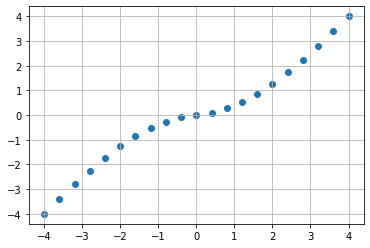

In [337]:
#visualization
mask_line = np.zeros(Nnode)
xx = np.zeros(Nnode)
yy = np.zeros(Nnode)
for i in range(Nnode):
    if (np.linalg.norm(coord[i][0])<1e-6):
        mask_line[i]=1
    xx[i]=coord[i][0]
    yy[i]=coord[i][1]

u_line = [x for i,x in enumerate(u) if  np.linalg.norm(mask_line[i]-1)<1e-6]
y_line = [x for i,x in enumerate(yy) if np.linalg.norm(mask_line[i]-1)<1e-6]
u_ref_line =[u_ref(coord[i][0],coord[i][1]) for i in range(Nnode) if mask_line[i]==1]

fig, ax = plt.subplots()
l1 = ax.scatter(y_line, u_line)
#l2 = ax.scatter(y_line, u_ref_line)
plt.grid()

In [265]:
omega

[array([0.50848317, 0.13052619, 0.13052619, 0.13052619, 0.13052619,
        0.13052619, 0.13052619, 0.13052619, 0.13052619, 0.13052619,
        0.13052619, 0.13052619, 0.13052619, 0.13052619, 0.13052619,
        0.13052619, 0.13052619, 0.13052619, 0.13052619, 0.13052619,
        0.13052619, 0.13052619, 0.13052619, 0.13052619, 0.13052619,
        0.13052619, 0.13052619, 0.13052619, 0.13052619, 0.13052619,
        0.13052619, 0.13052619, 0.13052619, 0.13052619, 0.13052619,
        0.13052619, 0.13052619, 0.13052619, 0.13052619, 0.13052619,
        0.13052619, 0.13052619, 0.13052619, 0.13052619, 0.13052619,
        0.13052619, 0.13052619, 0.53298609, 0.03270156]),
 array([0.13080626, 7.64489415, 0.13080626, 7.64489415]),
 array([0.13080626, 7.64489415, 0.13080626, 7.64489415]),
 array([0.13080626, 7.64489415, 0.13080626, 7.64489415]),
 array([0.13080626, 7.64489415, 0.13080626, 7.64489415]),
 array([0.13080626, 7.64489415, 0.13080626, 7.64489415]),
 array([0.13080626, 7.64489415, 0.130806